## Week 10 Homework

---


In [109]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import xarray as xr

### Q1: perform Bayesian Logistic Regression 

- For a binary outcome dataset you find interesting (perhaps from kaggle.com?)
- Model the outcome as a bernoulli random variable and use a **logit link** function
- Use `pm.Normal('betas', mu=0, sigma=1, shape=p)` rather than the `pm.MvNormal` version
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics

---


In [2]:
# Load the dataset
data = pd.read_csv('song_data.csv').dropna()

# Display the first few rows of the dataframe to understand its structure
data.head()

song_name  song_popularity  song_duration_ms  \
0  Boulevard of Broken Dreams               73            262333   
1                  In The End               66            216933   
2           Seven Nation Army               76            231733   
3                  By The Way               74            216933   
4           How You Remind Me               56            223826   

   acousticness  danceability  energy  instrumentalness  key  liveness  \
0      0.005520         0.496   0.682          0.000029    8    0.0589   
1      0.010300         0.542   0.853          0.000000    3    0.1080   
2      0.008170         0.737   0.463          0.447000    0    0.2550   
3      0.026400         0.451   0.970          0.003550    0    0.1020   
4      0.000954         0.447   0.766          0.000000   10    0.1130   

   loudness  audio_mode  speechiness    tempo  time_signature  audio_valence  
0    -4.095           1       0.0294  167.060               4          0.474  
1    -6.407           0       0.0498  105.256               4          0.370  
2    -7.828           1       0.0792  123.881               4          0.324  
3    -4.938           1       0.1070  122.444               4          0.198  
4    -5.065           1       0.0313  172.011               4          0.574

In [3]:
# List of numerical columns
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Use IQR to treat outliers if the normality is not fulfilled so that z-score method cannot be used
# Calculate IQR for each numerical column and determine outlier boundaries
Q1 = data[numerical_cols].quantile(0.01)
Q99 = data[numerical_cols].quantile(0.99)
IQR = Q99 - Q1

# Determine outlier boundaries
lower_bound = Q1
upper_bound = Q99

# Identify outliers
outliers = (data[numerical_cols] < lower_bound) | (data[numerical_cols] > upper_bound)

# Remove outliers from the dataset
data = data[~outliers.any(axis=1)]
data.head()

song_name  song_popularity  song_duration_ms  \
0  Boulevard of Broken Dreams               73            262333   
1                  In The End               66            216933   
2           Seven Nation Army               76            231733   
3                  By The Way               74            216933   
4           How You Remind Me               56            223826   

   acousticness  danceability  energy  instrumentalness  key  liveness  \
0      0.005520         0.496   0.682          0.000029    8    0.0589   
1      0.010300         0.542   0.853          0.000000    3    0.1080   
2      0.008170         0.737   0.463          0.447000    0    0.2550   
3      0.026400         0.451   0.970          0.003550    0    0.1020   
4      0.000954         0.447   0.766          0.000000   10    0.1130   

   loudness  audio_mode  speechiness    tempo  time_signature  audio_valence  
0    -4.095           1       0.0294  167.060               4          0.474  
1    -6.407           0       0.0498  105.256               4          0.370  
2    -7.828           1       0.0792  123.881               4          0.324  
3    -4.938           1       0.1070  122.444               4          0.198  
4    -5.065           1       0.0313  172.011               4          0.574

In [6]:
# Normalize/Scale Data
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data[numerical_cols]), columns=numerical_cols)

# Combine scaled numerical data with non-numerical data
data_final = pd.concat([data.drop(columns=numerical_cols).reset_index(drop=True), data_scaled], axis=1)

data_final.head()

song_name  song_popularity  song_duration_ms  \
0  Boulevard of Broken Dreams         0.768421          0.508666   
1                  In The End         0.694737          0.361886   
2           Seven Nation Army         0.800000          0.409735   
3                  By The Way         0.778947          0.361886   
4           How You Remind Me         0.589474          0.384171   

   acousticness  danceability    energy  instrumentalness       key  liveness  \
0      0.005597      0.374821  0.671263          0.000031  0.727273  0.028575   
1      0.010475      0.440629  0.859901          0.000000  0.272727  0.097691   
2      0.008302      0.719599  0.429675          0.478587  0.000000  0.304617   
3      0.026904      0.310443  0.988969          0.003801  0.000000  0.089245   
4      0.000938      0.304721  0.763927          0.000000  0.909091  0.104730   

   loudness  audio_mode  speechiness     tempo  time_signature  audio_valence  
0  0.901324         1.0     0.007870  0.788501             0.5       0.460913  
1  0.784029         0.0     0.055093  0.286523             0.5       0.346728  
2  0.711937         1.0     0.123148  0.437797             0.5       0.296223  
3  0.858556         1.0     0.187500  0.426126             0.5       0.157883  
4  0.852113         1.0     0.012269  0.828713             0.5       0.570707

In [7]:
# Model the outcome song_popularity as a binary variable
data_final['song_popularity'] = np.where(
    data_final['song_popularity'] <= 0.3, 0, 1
)

data_final.head()

song_name  song_popularity  song_duration_ms  \
0  Boulevard of Broken Dreams                1          0.508666   
1                  In The End                1          0.361886   
2           Seven Nation Army                1          0.409735   
3                  By The Way                1          0.361886   
4           How You Remind Me                1          0.384171   

   acousticness  danceability    energy  instrumentalness       key  liveness  \
0      0.005597      0.374821  0.671263          0.000031  0.727273  0.028575   
1      0.010475      0.440629  0.859901          0.000000  0.272727  0.097691   
2      0.008302      0.719599  0.429675          0.478587  0.000000  0.304617   
3      0.026904      0.310443  0.988969          0.003801  0.000000  0.089245   
4      0.000938      0.304721  0.763927          0.000000  0.909091  0.104730   

   loudness  audio_mode  speechiness     tempo  time_signature  audio_valence  
0  0.901324         1.0     0.007870  0.788501             0.5       0.460913  
1  0.784029         0.0     0.055093  0.286523             0.5       0.346728  
2  0.711937         1.0     0.123148  0.437797             0.5       0.296223  
3  0.858556         1.0     0.187500  0.426126             0.5       0.157883  
4  0.852113         1.0     0.012269  0.828713             0.5       0.570707

In [8]:
data_final.shape

(15939, 15)

In [9]:
X = data_final.drop(columns=["song_name", "song_popularity"]).values
y = data_final["song_popularity"].values

# Too many observations which gear down the process
# Randomly select 5000 indices from the dataset
random_indices = np.random.choice(X.shape[0], 100, replace=False)

# Subset X and y based on the selected indices
X_reduced = X[random_indices]
y_reduced = y[random_indices]

# Verify the new shapes
X_reduced.shape, y_reduced.shape

((100, 13), (100,))

In [11]:
p = X_reduced.shape[1]
n = X_reduced.shape[0]

with pm.Model() as LR:
    betas = pm.Normal('betas', mu=0, sigma=1, shape=p)
    alpha = pm.Normal("alpha", mu=0, sigma=1)

    # Logit link -> p = sigmoid(mu)
    p_ = pm.math.sigmoid(alpha + pm.math.dot(X_reduced, betas))
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y_reduced)
    
with LR:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [12]:
az.summary(idata, round_to=5, hdi_prob=0.95)

mean       sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
alpha      0.45679  0.79447  -1.14549    1.95411    0.01058  0.01319   
betas[0]  -0.43126  0.85608  -2.07329    1.22321    0.01159  0.01419   
betas[1]  -0.07820  0.78619  -1.55286    1.48544    0.00915  0.01282   
betas[2]   0.68589  0.84393  -0.90548    2.38061    0.01017  0.01440   
betas[3]   0.22844  0.83502  -1.42719    1.81002    0.01010  0.01429   
betas[4]   0.57827  0.86894  -1.10800    2.28352    0.01136  0.01524   
betas[5]   0.80888  0.71144  -0.56791    2.16908    0.00890  0.01206   
betas[6]  -0.24983  0.87711  -1.97286    1.40005    0.01081  0.01476   
betas[7]   0.76410  0.84975  -0.92008    2.39944    0.01054  0.01477   
betas[8]   0.99419  0.58406  -0.14359    2.14629    0.00756  0.01108   
betas[9]  -0.08697  0.88550  -1.73783    1.69725    0.01142  0.01501   
betas[10]  0.38932  0.86446  -1.35428    1.98408    0.01171  0.01560   
betas[11] -0.03721  0.94707  -1.84172    1.84386    0.01143  0.01797   
betas[12]  0.13279  0.81285  -1.49704    1.74557    0.00982  0.01481   

             ess_bulk    ess_tail    r_hat  
alpha      5661.81942  2785.69982  1.00052  
betas[0]   5431.50311  2751.46402  1.00075  
betas[1]   7395.39145  2946.39483  0.99977  
betas[2]   6884.11424  2977.92349  1.00037  
betas[3]   6862.01816  2979.37581  1.00000  
betas[4]   5810.24112  2495.46381  1.00479  
betas[5]   6373.54832  2561.50640  0.99956  
betas[6]   6622.51110  2744.26166  1.00191  
betas[7]   6527.83121  2823.72070  1.00067  
betas[8]   5991.95126  2778.01416  1.00038  
betas[9]   6026.01935  2641.63239  0.99982  
betas[10]  5444.69703  2977.73710  1.00434  
betas[11]  7273.80416  2951.23095  1.00382  
betas[12]  6887.83697  2630.67196  1.00117

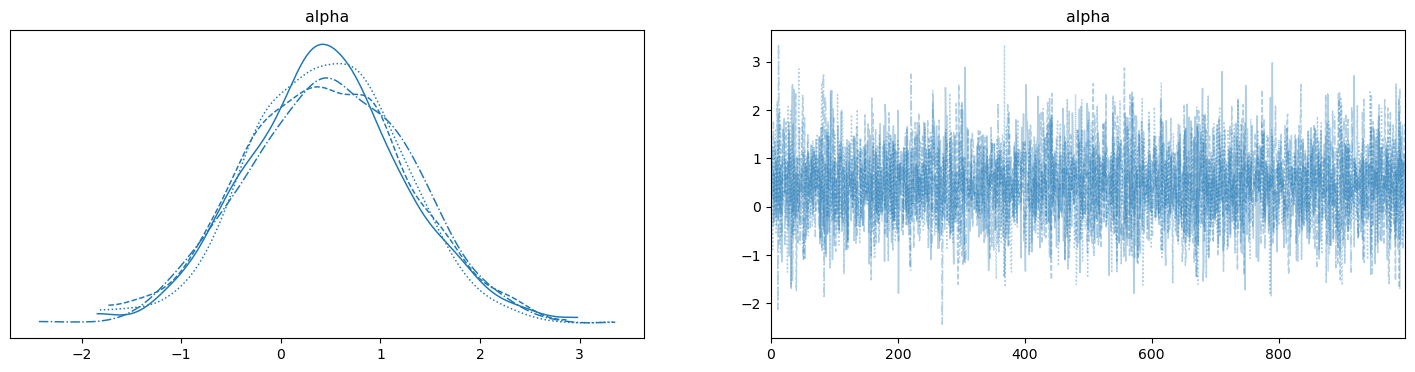

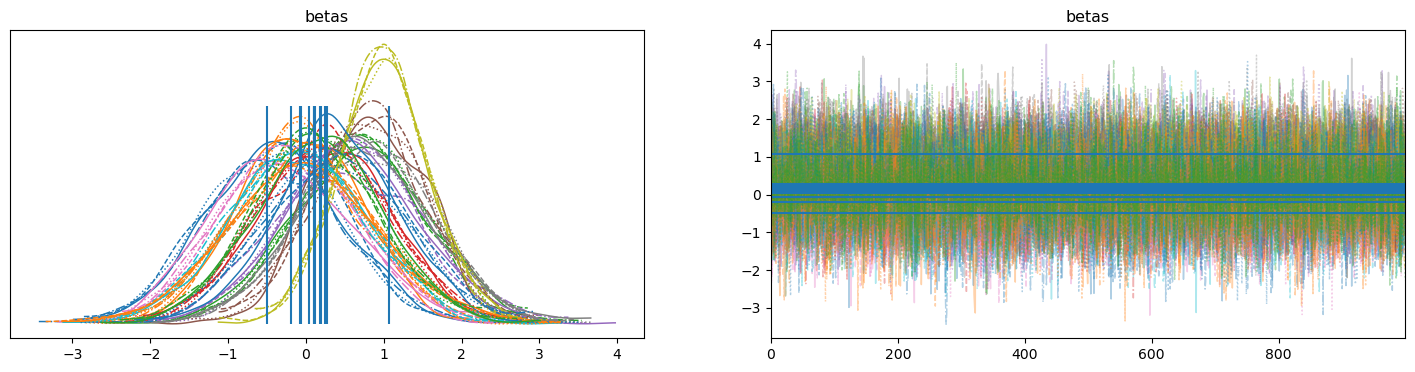

In [14]:
fig,ax = plt.subplots(1,2,figsize=(18,4))
fig2,ax2 = plt.subplots(1,2,figsize=(18,4))
az.plot_trace(idata, axes=np.r_[ax[0],ax[1],ax2[0],ax2[1]].reshape(2,2))

ax2[0].vlines(np.linalg.inv(X_reduced.T.dot(X_reduced)).dot(X_reduced.T.dot(y_reduced))[:13], ymin=0, ymax=ax[0].get_ylim()[-1])
ax2[1].hlines(np.linalg.inv(X_reduced.T.dot(X_reduced)).dot(X_reduced.T.dot(y_reduced))[:13], xmin=0, xmax=ax[1].get_xlim()[-1]);

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'betas\n0'}>,
        <Axes: title={'center': 'betas\n1'}>,
        <Axes: title={'center': 'betas\n2'}>],
       [<Axes: title={'center': 'betas\n3'}>,
        <Axes: title={'center': 'betas\n4'}>,
        <Axes: title={'center': 'betas\n5'}>,
        <Axes: title={'center': 'betas\n6'}>],
       [<Axes: title={'center': 'betas\n7'}>,
        <Axes: title={'center': 'betas\n8'}>,
        <Axes: title={'center': 'betas\n9'}>,
        <Axes: title={'center': 'betas\n10'}>],
       [<Axes: title={'center': 'betas\n11'}>,
        <Axes: title={'center': 'betas\n12'}>, <Axes: >, <Axes: >]],
      dtype=object)

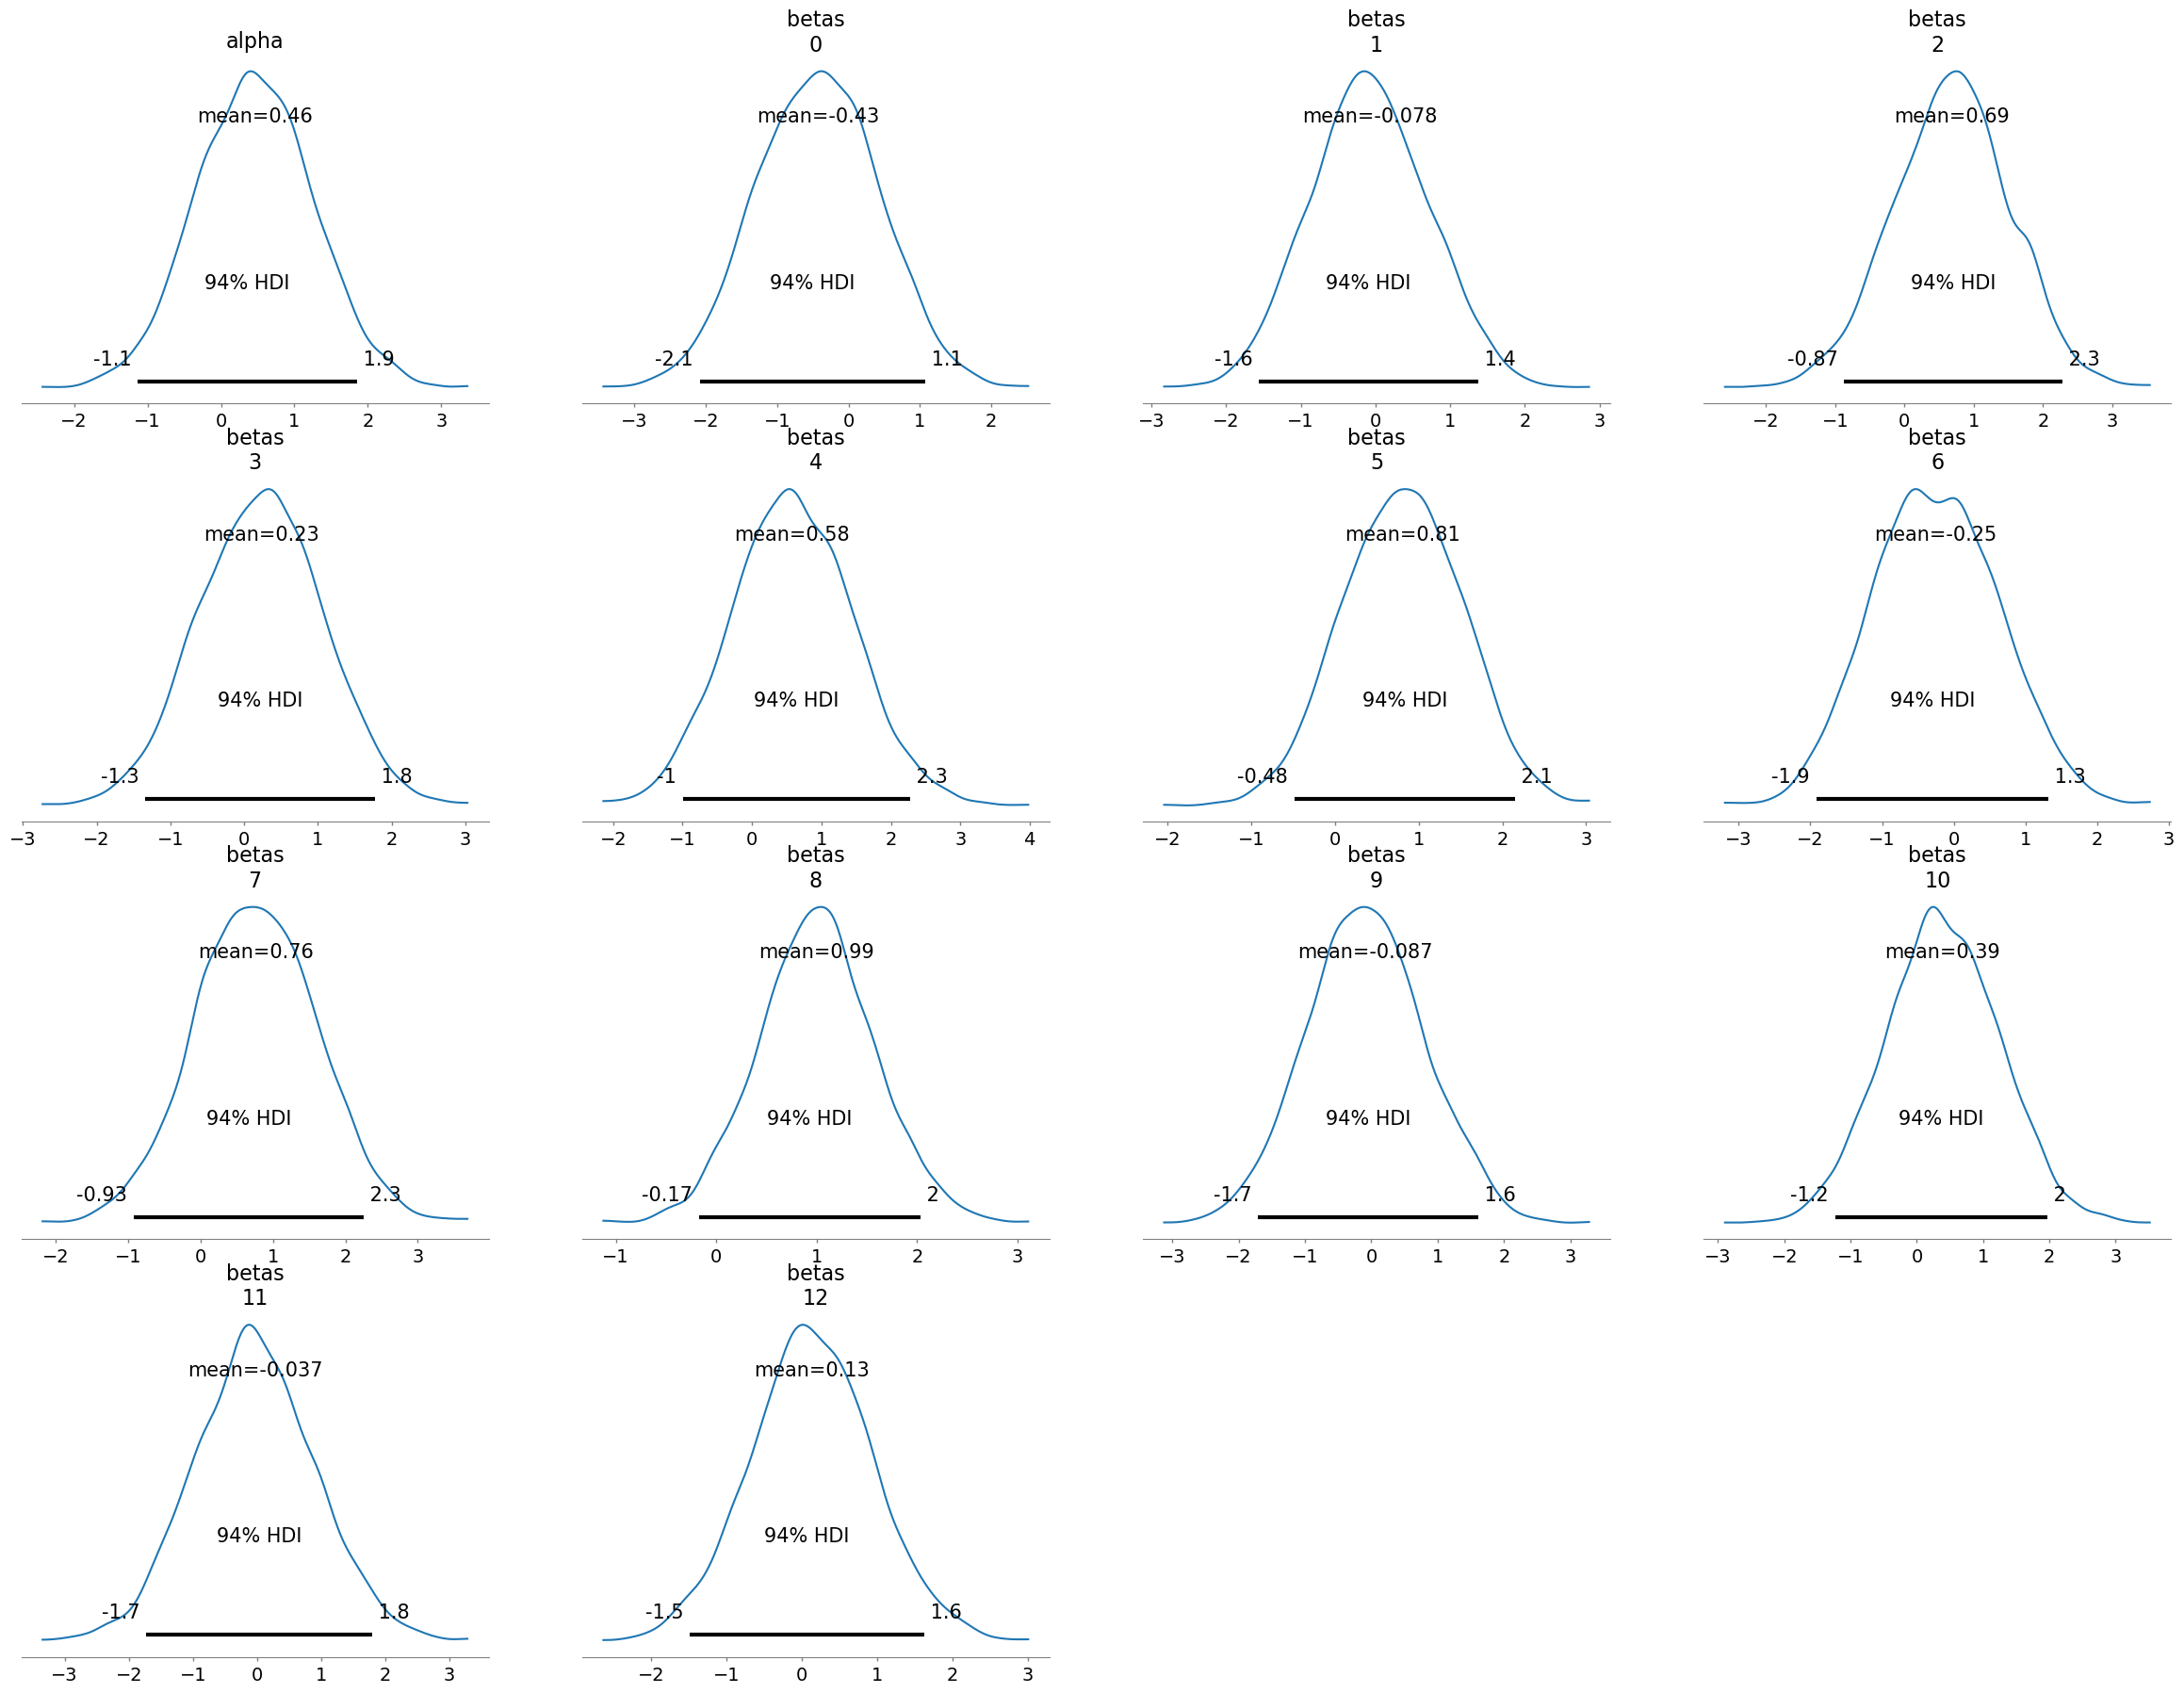

In [15]:
# Posterior analysis
az.plot_posterior(idata)

### Q2: perform Bayesian Multivariate Regression

- For a data set for which modeling multiple continuous outcomes might be interesting (perhaps from kaggle.com?)
- Use `pm.Normal('betas', mu=0, sigma=1, shape=(p,m))` rather than a `pm.MvNormal` alternative
- Use `y = pm.MvNormal('y', mu=X@betas, chol=L, observed=x)` for `(n,m)` shaped `y` and `(n,p)` shaped `X`
- Downsample your dataset to tentatively explore the effect of different values of `n`,`m`,`p` and 
    - report on your findings and based on that 
    - choose a "reasonably small" sized data set to perform an actual analysis
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics

---

In [23]:
# Normalize/Scale Data
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data[numerical_cols]), columns=numerical_cols)

# Combine scaled numerical data with non-numerical data
data_final = pd.concat([data.drop(columns=numerical_cols).reset_index(drop=True), data_scaled], axis=1)

data_final.head()

song_name  song_popularity  song_duration_ms  \
0  Boulevard of Broken Dreams         0.768421          0.508666   
1                  In The End         0.694737          0.361886   
2           Seven Nation Army         0.800000          0.409735   
3                  By The Way         0.778947          0.361886   
4           How You Remind Me         0.589474          0.384171   

   acousticness  danceability    energy  instrumentalness       key  liveness  \
0      0.005597      0.374821  0.671263          0.000031  0.727273  0.028575   
1      0.010475      0.440629  0.859901          0.000000  0.272727  0.097691   
2      0.008302      0.719599  0.429675          0.478587  0.000000  0.304617   
3      0.026904      0.310443  0.988969          0.003801  0.000000  0.089245   
4      0.000938      0.304721  0.763927          0.000000  0.909091  0.104730   

   loudness  audio_mode  speechiness     tempo  time_signature  audio_valence  
0  0.901324         1.0     0.007870  0.788501             0.5       0.460913  
1  0.784029         0.0     0.055093  0.286523             0.5       0.346728  
2  0.711937         1.0     0.123148  0.437797             0.5       0.296223  
3  0.858556         1.0     0.187500  0.426126             0.5       0.157883  
4  0.852113         1.0     0.012269  0.828713             0.5       0.570707

### 1st Trial (n=100, p=9, m=3)

In [134]:
X = data_final.drop(columns=["song_name", "song_popularity", "energy", "liveness", "song_duration_ms", "time_signature"]).values
y = data_final[["song_popularity", "energy", "liveness"]].values

# Too many observations which gear down the process
# Randomly select 5000 indices from the dataset
random_indices = np.random.choice(X.shape[0], 100, replace=False)

# Subset X and y based on the selected indices
X_reduced = X[random_indices]
y_reduced = y[random_indices]

# Verify the new shapes
X_reduced.shape, y_reduced.shape

((100, 9), (100, 3))

In [135]:
p = X_reduced.shape[1]
n = X_reduced.shape[0]
m = y_reduced.shape[1]   # dimension of the multivariate outcome

with pm.Model() as MNV_LKJ:
    
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0, 
                                 sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p,m))
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    y = pm.MvNormal('y', mu=X_reduced@betas, chol=L,  #cov=Sigma
                    observed=y_reduced)   
    
    idata2_100_9_3 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, betas]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 195 seconds.


<Axes: >

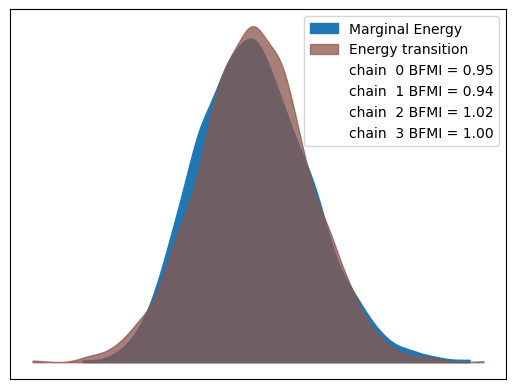

In [136]:
az.plot_energy(idata2_100_9_3)

array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>]], dtype=object)

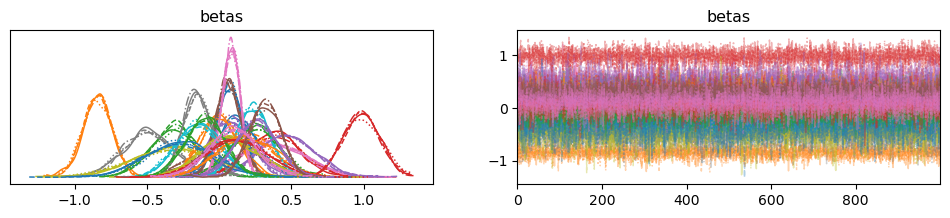

In [137]:
az.plot_trace(idata2_100_9_3, var_names='betas')

### 2nd Trial (n=50, p=9, m=3)

In [138]:
X = data_final.drop(columns=["song_name", "song_popularity", "energy", "liveness", "song_duration_ms", "time_signature"]).values
y = data_final[["song_popularity", "energy", "liveness"]].values

# Too many observations which gear down the process
# Randomly select 5000 indices from the dataset
random_indices = np.random.choice(X.shape[0], 50, replace=False)

# Subset X and y based on the selected indices
X_reduced = X[random_indices]
y_reduced = y[random_indices]

# Verify the new shapes
X_reduced.shape, y_reduced.shape

((50, 9), (50, 3))

In [139]:
p = X_reduced.shape[1]
n = X_reduced.shape[0]
m = y_reduced.shape[1]   # dimension of the multivariate outcome

with pm.Model() as MNV_LKJ:
    
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0, 
                                 sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p,m))
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    y = pm.MvNormal('y', mu=X_reduced@betas, chol=L,  #cov=Sigma
                    observed=y_reduced)   
    
    idata2_50_9_3 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 202 seconds.


<Axes: >

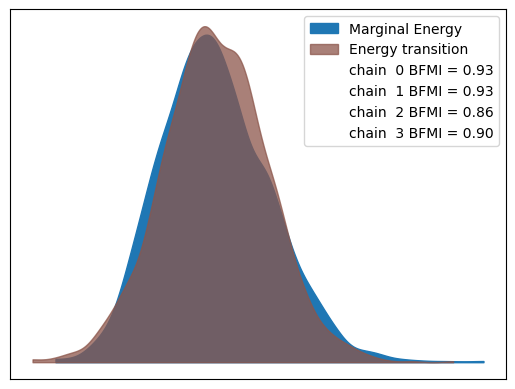

In [140]:
az.plot_energy(idata2_50_9_3)

array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>]], dtype=object)

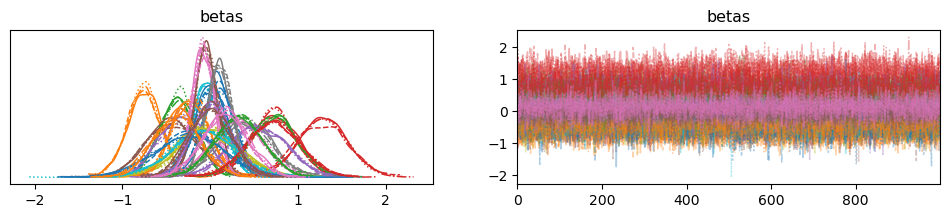

In [141]:
az.plot_trace(idata2_50_9_3, var_names='betas')

### 3rd Trial (n=100, p=6, m=3)

In [142]:
X = data_final.drop(columns=["song_name", "song_popularity", "energy", "liveness", "song_duration_ms", "time_signature", "audio_mode", "audio_valence", "acousticness"]).values
y = data_final[["song_popularity", "energy", "liveness"]].values

# Too many observations which gear down the process
# Randomly select 5000 indices from the dataset
random_indices = np.random.choice(X.shape[0], 100, replace=False)

# Subset X and y based on the selected indices
X_reduced = X[random_indices]
y_reduced = y[random_indices]

# Verify the new shapes
X_reduced.shape, y_reduced.shape

((100, 6), (100, 3))

In [143]:
p = X_reduced.shape[1]
n = X_reduced.shape[0]
m = y_reduced.shape[1]   # dimension of the multivariate outcome

with pm.Model() as MNV_LKJ:
    
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0, 
                                 sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p,m))
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    y = pm.MvNormal('y', mu=X_reduced@betas, chol=L,  #cov=Sigma
                    observed=y_reduced)   
    
    idata2_100_6_3 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, betas]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 144 seconds.


<Axes: >

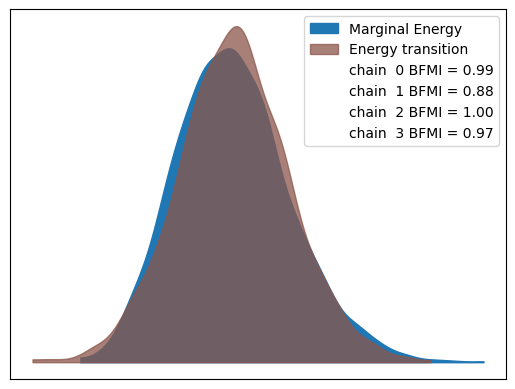

In [144]:
az.plot_energy(idata2_100_6_3)

array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>]], dtype=object)

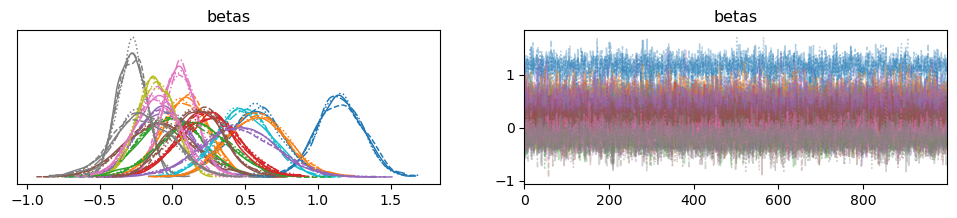

In [145]:
az.plot_trace(idata2_100_6_3, var_names='betas')

### 4th Trial (n=100, p=9, m=5)

In [146]:
X = data_final.drop(columns=["song_name", "song_popularity", "energy", "liveness", "song_duration_ms", "time_signature"]).values
y = data_final[["song_popularity", "energy", "liveness", "song_duration_ms", "time_signature"]].values

# Too many observations which gear down the process
# Randomly select 5000 indices from the dataset
random_indices = np.random.choice(X.shape[0], 100, replace=False)

# Subset X and y based on the selected indices
X_reduced = X[random_indices]
y_reduced = y[random_indices]

# Verify the new shapes
X_reduced.shape, y_reduced.shape

((100, 9), (100, 5))

In [147]:
p = X_reduced.shape[1]
n = X_reduced.shape[0]
m = y_reduced.shape[1]   # dimension of the multivariate outcome

with pm.Model() as MNV_LKJ:
    
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0, 
                                 sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p,m))
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    y = pm.MvNormal('y', mu=X_reduced@betas, chol=L,  #cov=Sigma
                    observed=y_reduced)   
    
    idata2_100_9_5 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 261 seconds.


<Axes: >

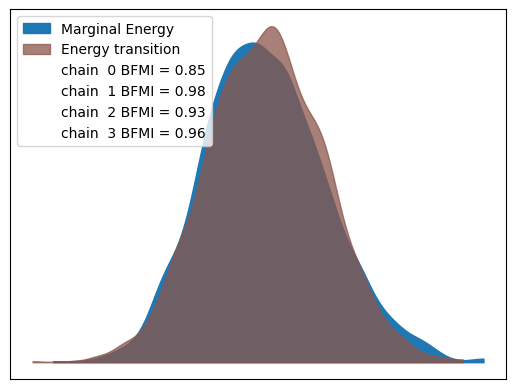

In [148]:
az.plot_energy(idata2_100_9_5)

array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>]], dtype=object)

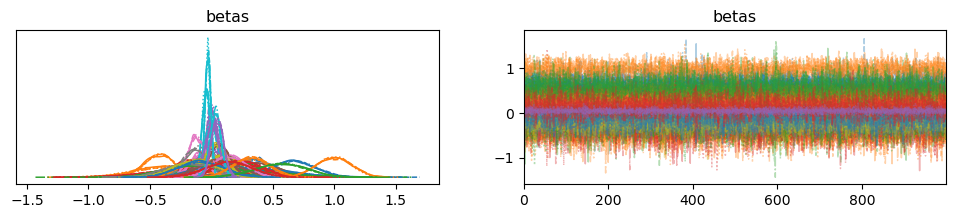

In [149]:
az.plot_trace(idata2_100_9_5, var_names='betas')

Across these four trials of the Bayesian multivariate regression, the marginal energy (blue) and energy transition (brown) plots—along with their BFMI values—highlight how changing n, p, and m can impact sampling efficiency. In the first scenario (n=100, p=9, m=3), two of the chains exhibit BFMI values at or above 1.0, and two slightly below, indicating generally robust exploration of the posterior. The second scenario (n=50, p=9, m=3), shows BFMI values in the 0.86–0.93 range, somewhat lower but still within a workable regime; fewer data points can produce higher posterior uncertainty, occasionally making transitions less stable. Moving to the third scenario (n=100, p=6, m=3), BFMI values range from 0.88 up to 1, suggesting slightly simpler parameter space (fewer predictors) and generally good sampler performance. Finally, in the fourth scenario (n=100, p=9, m=5), the sampler is tackling a higher-dimensional outcome (five dimensions), yet achieves BFMI values around 0.85–0.98—demonstrating that while more complex models can strain sampling, the chains still converge reasonably well, but lower than the first and the third regimes. Overall, these energy distributions and BFMI metrics suggest that the multivariate regression is sampling effectively across a range of dimensionalities and sample sizes, with some expected variation in efficiency as p, n, and, and especially m changes.

### Final Trial and Bayesian Analysis

In [127]:
X = data_final.drop(columns=["song_name", "song_popularity", "energy", "liveness"]).values
y = data_final[["song_popularity", "energy", "liveness"]].values

# Too many observations which gear down the process
# Randomly select 5000 indices from the dataset
random_indices = np.random.choice(X.shape[0], 200, replace=False)

# Subset X and y based on the selected indices
X_reduced = X[random_indices]
y_reduced = y[random_indices]

# Verify the new shapes
X_reduced.shape, y_reduced.shape

((200, 11), (200, 3))

In [128]:
p = X_reduced.shape[1]
n = X_reduced.shape[0]
m = y_reduced.shape[1]   # dimension of the multivariate outcome
# a_cov = stats.invwishart(df=m+2, scale=np.eye(m)).rvs()

with pm.Model() as MNV_LKJ:
    
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0, 
                                 sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p,m))
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    y = pm.MvNormal('y', mu=X_reduced@betas, chol=L,  #cov=Sigma
                    observed=y_reduced)   
    
    idata2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 203 seconds.


In [129]:
az.summary(idata2, round_to=5, hdi_prob=0.95)

mean       sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
Sigma[0, 0]   0.13655  0.01439   0.11114    0.16664    0.00022  0.00022   
Sigma[0, 1]  -0.00114  0.00896  -0.01850    0.01669    0.00015  0.00015   
Sigma[0, 2]   0.00263  0.01330  -0.02255    0.02948    0.00019  0.00025   
Sigma[1, 0]  -0.00114  0.00896  -0.01850    0.01669    0.00015  0.00015   
Sigma[1, 1]   0.10839  0.01108   0.08768    0.13069    0.00017  0.00019   
Sigma[1, 2]   0.01269  0.01177  -0.00902    0.03621    0.00017  0.00019   
Sigma[2, 0]   0.00263  0.01330  -0.02255    0.02948    0.00019  0.00025   
Sigma[2, 1]   0.01269  0.01177  -0.00902    0.03621    0.00017  0.00019   
Sigma[2, 2]   0.23718  0.02507   0.18970    0.28628    0.00039  0.00043   
betas[0, 0]   0.11863  0.08083  -0.04295    0.27410    0.00124  0.00131   
betas[0, 1]   0.07113  0.07106  -0.06640    0.20760    0.00112  0.00107   
betas[0, 2]  -0.05642  0.10512  -0.25093    0.15935    0.00164  0.00161   
betas[1, 0]   0.32838  0.09087   0.14475    0.50038    0.00140  0.00139   
betas[1, 1]  -0.61670  0.07964  -0.76520   -0.46035    0.00122  0.00118   
betas[1, 2]   0.04620  0.12023  -0.18369    0.27817    0.00191  0.00176   
betas[2, 0]   0.34670  0.12377   0.10612    0.59131    0.00222  0.00194   
betas[2, 1]  -0.12210  0.11166  -0.34035    0.09529    0.00202  0.00183   
betas[2, 2]   0.08642  0.16009  -0.22566    0.40233    0.00262  0.00236   
betas[3, 0]   0.09745  0.16354  -0.23663    0.41808    0.00244  0.00262   
betas[3, 1]   0.04526  0.14489  -0.24716    0.31745    0.00215  0.00203   
betas[3, 2]   0.21457  0.21776  -0.21189    0.65760    0.00353  0.00403   
betas[4, 0]   0.01424  0.08042  -0.14794    0.16736    0.00120  0.00130   
betas[4, 1]  -0.02795  0.07063  -0.17568    0.09910    0.00107  0.00108   
betas[4, 2]   0.01983  0.10512  -0.18942    0.22219    0.00179  0.00151   
betas[5, 0]   0.64316  0.12165   0.39736    0.87355    0.00219  0.00180   
betas[5, 1]   1.08663  0.10930   0.87147    1.30577    0.00188  0.00160   
betas[5, 2]   0.31747  0.15880  -0.01574    0.60892    0.00276  0.00232   
betas[6, 0]   0.12782  0.05742   0.02272    0.24428    0.00088  0.00088   
betas[6, 1]  -0.04692  0.05120  -0.15160    0.04705    0.00079  0.00077   
betas[6, 2]  -0.07202  0.07505  -0.22384    0.07085    0.00117  0.00106   
betas[7, 0]   0.05496  0.12463  -0.17809    0.30514    0.00203  0.00215   
betas[7, 1]  -0.17328  0.11145  -0.38491    0.04387    0.00166  0.00160   
betas[7, 2]   0.20559  0.15970  -0.09620    0.51837    0.00248  0.00234   
betas[8, 0]   0.00325  0.11410  -0.22363    0.23139    0.00173  0.00177   
betas[8, 1]   0.09736  0.09975  -0.09641    0.28979    0.00159  0.00146   
betas[8, 2]   0.05869  0.15091  -0.23997    0.34681    0.00237  0.00231   
betas[9, 0]   0.22884  0.34321  -0.47544    0.86523    0.00485  0.00557   
betas[9, 1]   0.11547  0.31327  -0.50689    0.72402    0.00450  0.00498   
betas[9, 2]   0.47717  0.42864  -0.33695    1.31622    0.00640  0.00653   
betas[10, 0] -0.04861  0.10156  -0.23753    0.15824    0.00157  0.00172   
betas[10, 1]  0.29185  0.09053   0.12032    0.47110    0.00132  0.00145   
betas[10, 2]  0.07669  0.13256  -0.19149    0.32179    0.00204  0.00207   
packed_L[0]   0.36902  0.01935   0.33338    0.40822    0.00030  0.00029   
packed_L[1]  -0.00310  0.02413  -0.05081    0.04336    0.00039  0.00040   
packed_L[2]   0.32791  0.01659   0.29593    0.36071    0.00025  0.00027   
packed_L[3]   0.00710  0.03583  -0.06219    0.07685    0.00052  0.00067   
packed_L[4]   0.03854  0.03522  -0.03126    0.10428    0.00051  0.00057   
packed_L[5]   0.48216  0.02524   0.43351    0.53238    0.00038  0.00040   

                ess_bulk    ess_tail    r_hat  
Sigma[0, 0]   4249.27771  2811.75625  1.00008  
Sigma[0, 1]   3736.41569  2918.20987  1.00099  
Sigma[0, 2]   4665.25928  3048.55885  1.00072  
Sigma[1, 0]   3736.41569  2918.20987  1.00099  
Sigma[1, 1]   4241.77112  2965.49869  1.00076  
Sigma[1, 2]   4568.86871  2966.07861  1.00050  
Sigma

array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>]], dtype=object)

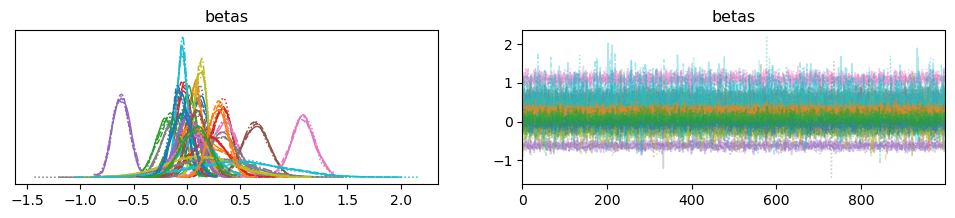

In [130]:
az.plot_trace(idata2, var_names='betas')

/opt/conda/lib/python3.11/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (48) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'Sigma\n0, 0'}>,
        <Axes: title={'center': 'Sigma\n0, 1'}>,
        <Axes: title={'center': 'Sigma\n0, 2'}>,
        <Axes: title={'center': 'Sigma\n1, 0'}>],
       [<Axes: title={'center': 'Sigma\n1, 1'}>,
        <Axes: title={'center': 'Sigma\n1, 2'}>,
        <Axes: title={'center': 'Sigma\n2, 0'}>,
        <Axes: title={'center': 'Sigma\n2, 1'}>],
       [<Axes: title={'center': 'Sigma\n2, 2'}>,
        <Axes: title={'center': 'betas\n0, 0'}>,
        <Axes: title={'center': 'betas\n0, 1'}>,
        <Axes: title={'center': 'betas\n0, 2'}>],
       [<Axes: title={'center': 'betas\n1, 0'}>,
        <Axes: title={'center': 'betas\n1, 1'}>,
        <Axes: title={'center': 'betas\n1, 2'}>,
        <Axes: title={'center': 'betas\n2, 0'}>],
       [<Axes: title={'center': 'betas\n2, 1'}>,
        <Axes: title={'center': 'betas\n2, 2'}>,
        <Axes: title={'center': 'betas\n3, 0'}>,
        <Axes: title={'center': 'betas\n3, 1'}>],
       [<Axes: 

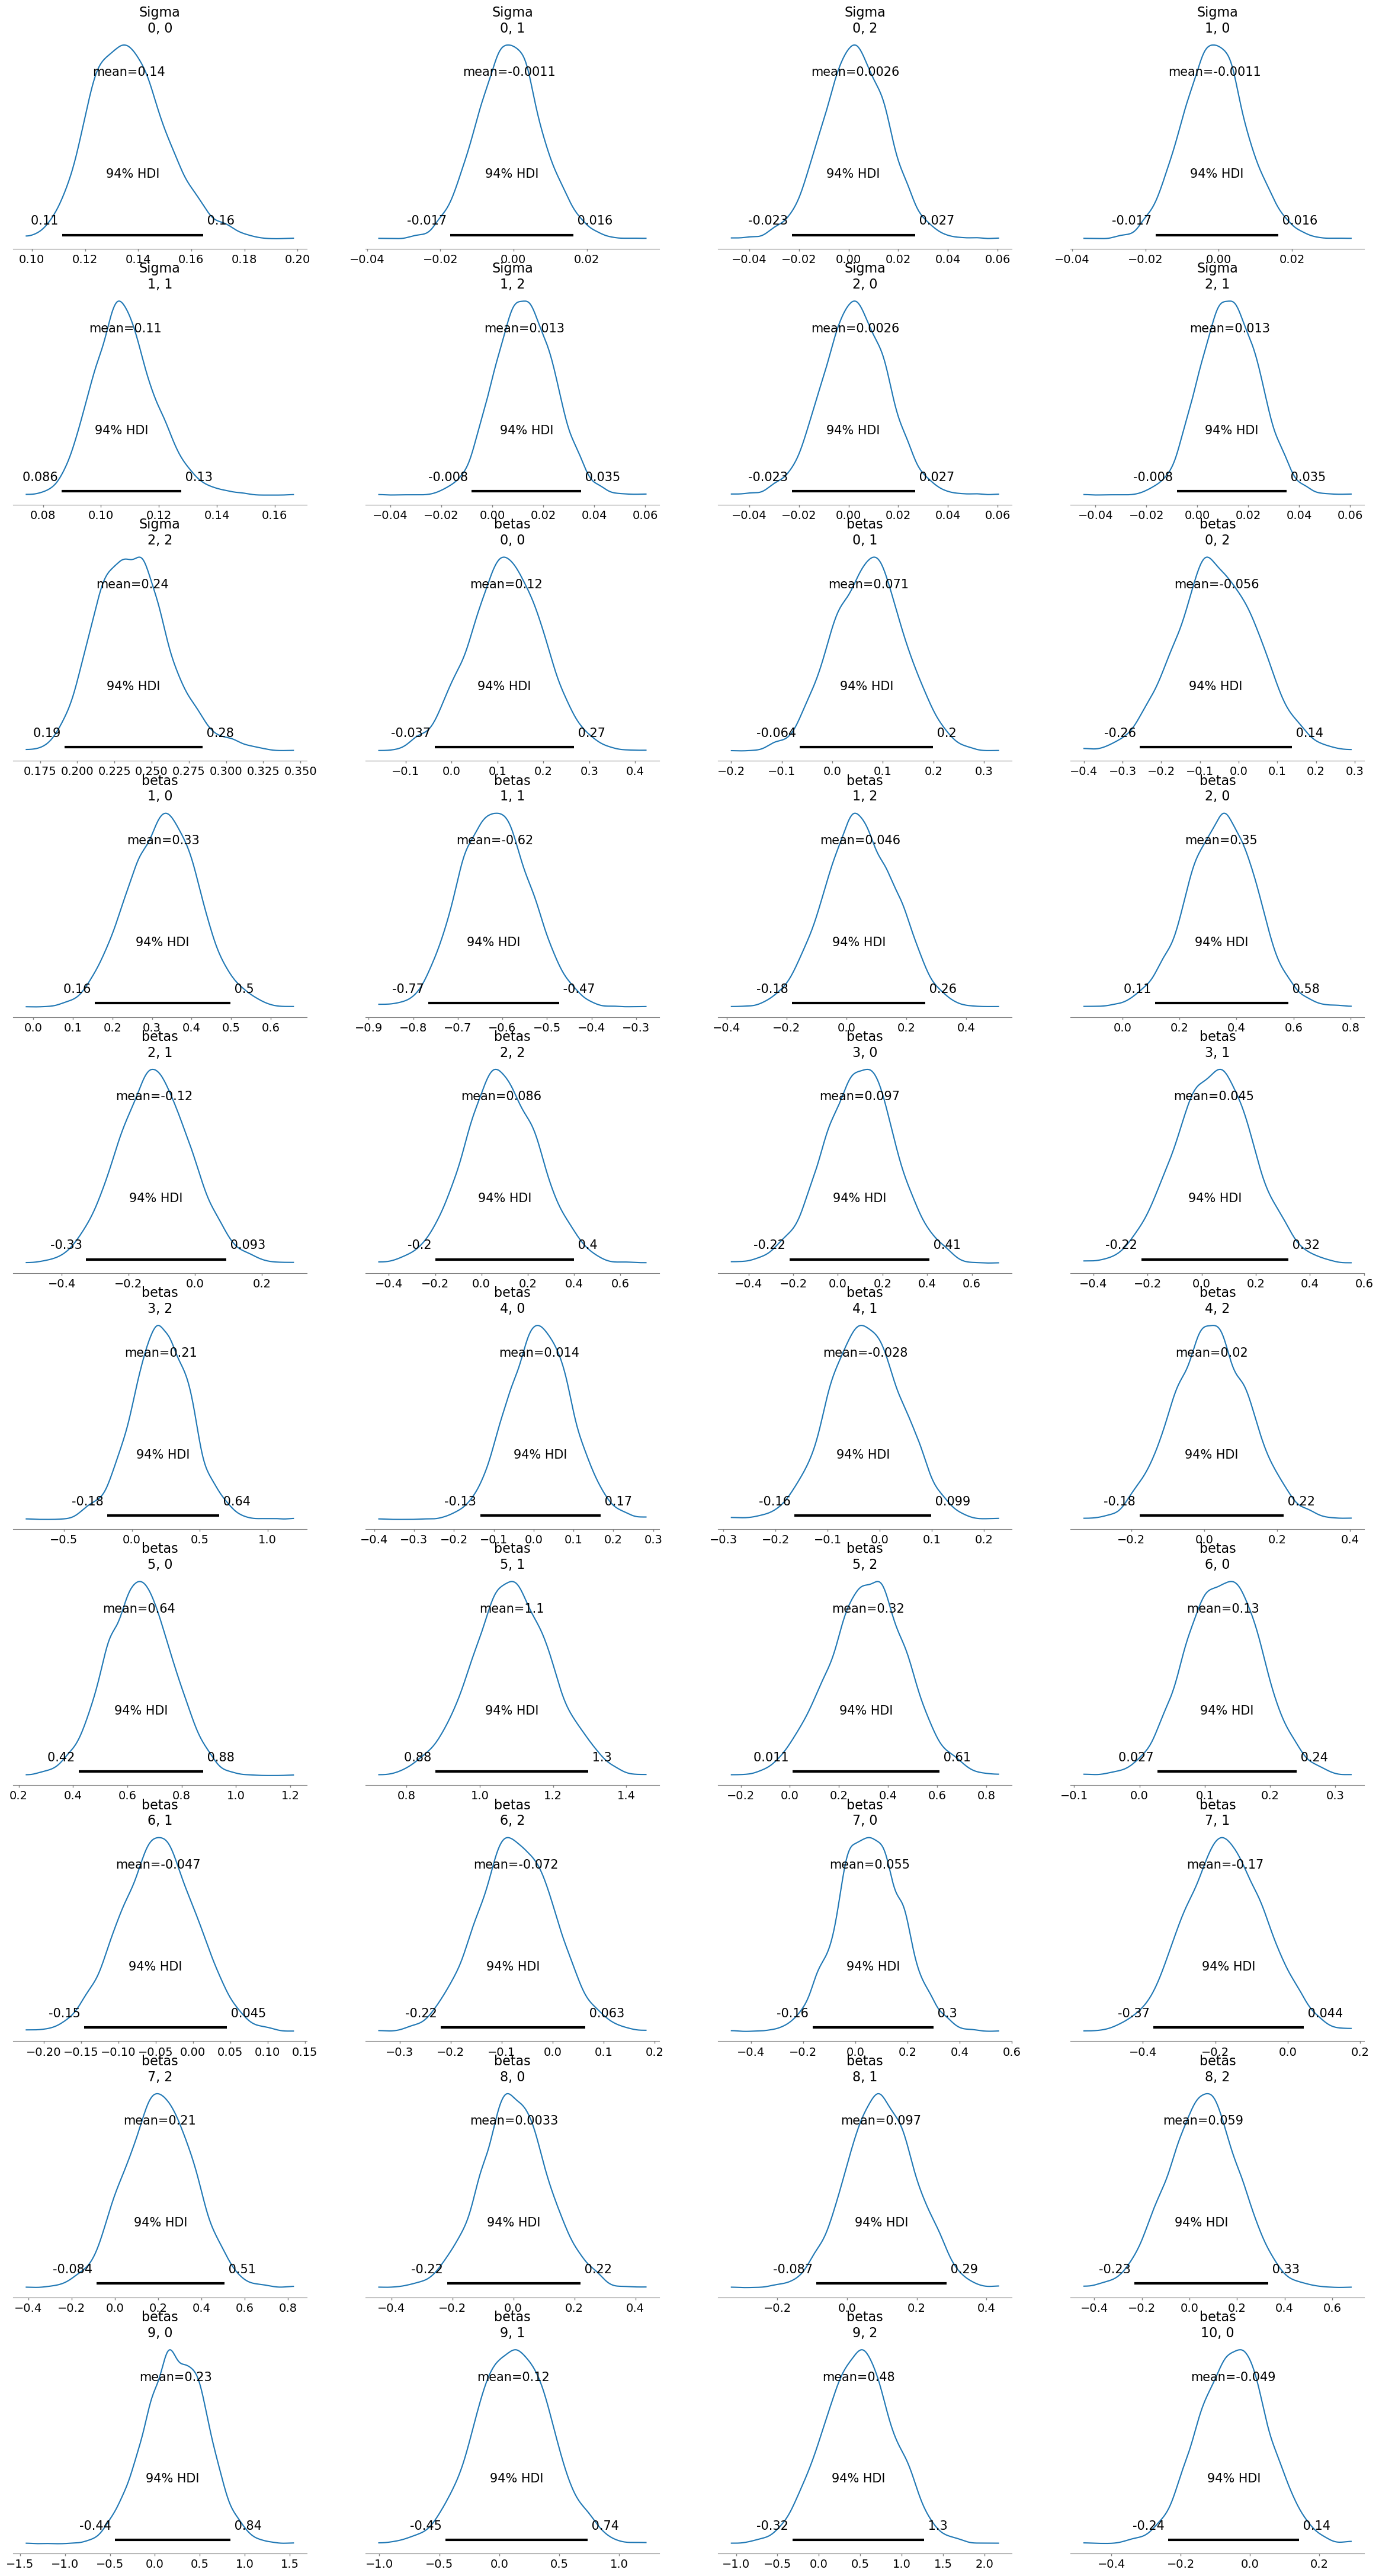

In [131]:
# Posterior analysis
az.plot_posterior(idata2)

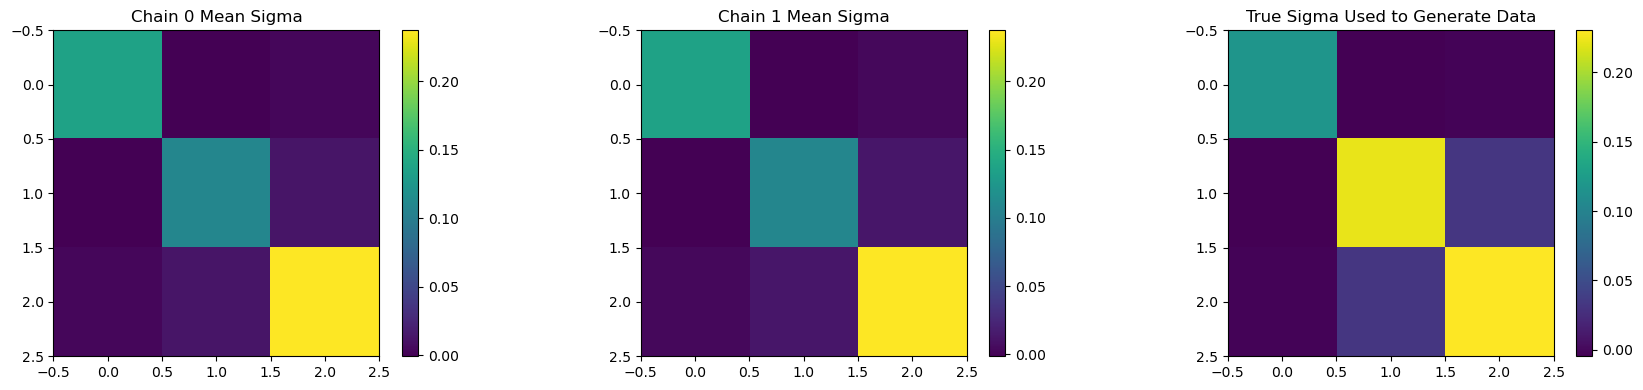

In [132]:
# Suppose m=3 for demonstration (3-dimensional outcome)
m = 3

a_cov = np.cov(y_reduced, rowvar=False)

# Create a figure with 3 subplots side by side
fig, ax = plt.subplots(1, 3, figsize=(18, 4))

# -------------------------------------------------------------------
# 1) Show the posterior mean Sigma for chain 0 in the first subplot
# -------------------------------------------------------------------
# The dimension of idata_mnv.posterior['Sigma'] is typically:
#   (chain, draw, m, m)
# We take the mean over 'draw', keeping chain dimension separate.

chain0_mean = idata2.posterior["Sigma"].mean(dim="draw")[0].values
im0 = ax[0].imshow(chain0_mean)
ax[0].set_title("Chain 0 Mean Sigma")
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

# -------------------------------------------------------------------
# 2) Show the posterior mean Sigma for chain 1 in the second subplot
# -------------------------------------------------------------------
chain1_mean = idata2.posterior["Sigma"].mean(dim="draw")[1].values
im1 = ax[1].imshow(chain1_mean)
ax[1].set_title("Chain 1 Mean Sigma")
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

# -------------------------------------------------------------------
# 3) Show the "true" Sigma used to generate data in the third subplot
#    (If you're using real data, this step is not relevant)
# -------------------------------------------------------------------
im2 = ax[2].imshow(a_cov)
ax[2].set_title("True Sigma Used to Generate Data")
fig.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

From the posterior plots, each entry of the posterior matrix shows a unimodal distribution that centers near the “true” covariance values used to simulate the data, suggesting the model is recovering these relationships reasonably well. The per-chain mean estimates align closely across chains, indicating consistent sampling despite minor variations. Meanwhile, the trace plots (bottom right) reveal good chain mixing and stable sampling—no large drifts or unresponsive segments—which is corroborated by the tight posterior distributions (bottom left) for beta. Overall, the MCMC diagnostics (e.g., trace behavior, unimodality, overlap across chains) indicate that the sampler has converged, and the posterior distributions provide credible intervals that encompass the true parameter values used in data generation.

### Probit Regression (as opposed to Logistic Regression)

- $\Phi$ is CDF of standard normal (and is also call the **inverse probit** function)
    - The **probit** function is $\Phi^{-1}$
- $z_i \sim N(x_i^\top\beta,1)$


$$\int \Phi(z_i)^{y_i} (1-\Phi(z_i))^{1-y_i}d\Phi(z) = \Phi(x_i^\top\beta)^{y_i} (1-\Phi(x_i^\top\beta))^{1-y_i} = p_i^{y_i} (1-p_i)^{1-y_i} $$

### Q3: perform Bayesian Multivariate Classification

- For a data set for which modeling multiple binary outcomes might be interesting (perhaps from kaggle.com?)
- Use `pm.Normal('betas', mu=0, sigma=1, shape=(p,m))` rather than a `pm.MvNormal` alternative
- Use `y = pm.Bernoulli('y', p=pm.math.invprobit(X@betas), observed=x)` for `(n,m)` shaped `y` and `(n,p)` shaped `X`
- Use latent `z = pm.MvNormal('z', mu=X@betas, chol=L)` as discussed in the "Generalized Linear Models (GLM)" section of the previous weeks lecture notes

> This provides normally distributed latent variables connected to the observed binary outcomes on which a latent covariance dependency structure may be modelled and estimated on the basis of imputing the unobserved latent variables based on their connection with the observed binary outcome variables.

- Downsample your dataset to tentatively explore the effect of different values of `n`,`m`,`p` and 
    - report on your findings and based on that 
    - choose a "reasonably small" sized data set to perform an actual analysis
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics

---

In [72]:
# Normalize/Scale Data
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data[numerical_cols]), columns=numerical_cols)

# Combine scaled numerical data with non-numerical data
data_final = pd.concat([data.drop(columns=numerical_cols).reset_index(drop=True), data_scaled], axis=1)

# Model the outcomes as a binary variable
data_final['song_popularity'] = np.where(
    data_final['song_popularity'] <= 0.3, 0, 1
)
data_final['energy'] = np.where(
    data_final['energy'] <= 0.5, 0, 1
)
data_final['liveness'] = np.where(
    data_final['liveness'] <= 0.2, 0, 1
)

data_final.head()

song_name  song_popularity  song_duration_ms  \
0  Boulevard of Broken Dreams                1          0.508666   
1                  In The End                1          0.361886   
2           Seven Nation Army                1          0.409735   
3                  By The Way                1          0.361886   
4           How You Remind Me                1          0.384171   

   acousticness  danceability  energy  instrumentalness       key  liveness  \
0      0.005597      0.374821       1          0.000031  0.727273         0   
1      0.010475      0.440629       1          0.000000  0.272727         0   
2      0.008302      0.719599       0          0.478587  0.000000         1   
3      0.026904      0.310443       1          0.003801  0.000000         0   
4      0.000938      0.304721       1          0.000000  0.909091         0   

   loudness  audio_mode  speechiness     tempo  time_signature  audio_valence  
0  0.901324         1.0     0.007870  0.788501             0.5       0.460913  
1  0.784029         0.0     0.055093  0.286523             0.5       0.346728  
2  0.711937         1.0     0.123148  0.437797             0.5       0.296223  
3  0.858556         1.0     0.187500  0.426126             0.5       0.157883  
4  0.852113         1.0     0.012269  0.828713             0.5       0.570707

### 1st Trial (n=100, p=9, m=3)

In [77]:
X = data_final.drop(columns=["song_name", "song_popularity", "energy", "liveness", "song_duration_ms", "time_signature"]).values
y = data_final[["song_popularity", "energy", "liveness"]].values

# Too many observations which gear down the process
# Randomly select 5000 indices from the dataset
random_indices = np.random.choice(X.shape[0], 100, replace=False)

# Subset X and y based on the selected indices
X_reduced = X[random_indices]
y_reduced = y[random_indices]

# Verify the new shapes
X_reduced.shape, y_reduced.shape

((100, 9), (100, 3))

In [78]:
df_describe = pd.DataFrame(y_reduced)
df_describe.describe()

0           1           2
count  100.000000  100.000000  100.000000
mean     0.870000    0.750000    0.280000
std      0.337998    0.435194    0.451261
min      0.000000    0.000000    0.000000
25%      1.000000    0.750000    0.000000
50%      1.000000    1.000000    0.000000
75%      1.000000    1.000000    1.000000
max      1.000000    1.000000    1.000000

In [79]:
p = X_reduced.shape[1]
n = X_reduced.shape[0]
m = y_reduced.shape[1]   # dimension of the multivariate outcome
# a_cov = stats.invwishart(df=m+2, scale=np.eye(m)).rvs()

with pm.Model() as GLM:
    
    L,R,std = pm.LKJCholeskyCov("R", n=m, eta=2.0, 
                                sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                compute_corr=True)
    #L = pm.expand_packed_triangular(m, packed_L)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p,m))
    #Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    z = pm.MvNormal('z', mu=X_reduced@betas, cov=R) #cov=Sigma
    # the probit is the inverse cdf of a standard normal
    # the inverse probit is the cdf of a standard normal
    y = pm.Bernoulli('y', p=pm.math.invprobit(z), observed=y_reduced)   
    # Integrating out z would give:
    #y = pm.Bernoulli('y', p=pm.math.invprobit(X@betas), observed=x)   
    
    idata3_100_9_3 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [R, betas, z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1167 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1108 divergences after tuning. Increase `target_accept` or reparameterize.


<Axes: >

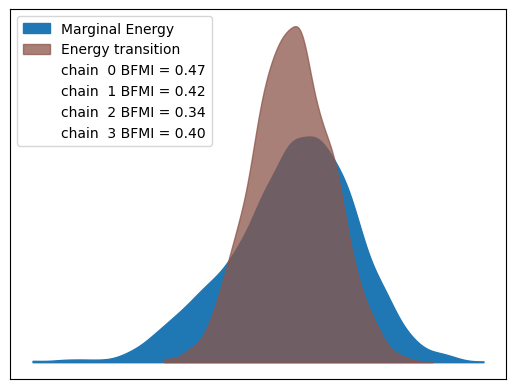

In [80]:
az.plot_energy(idata3_100_9_3)

array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>]], dtype=object)

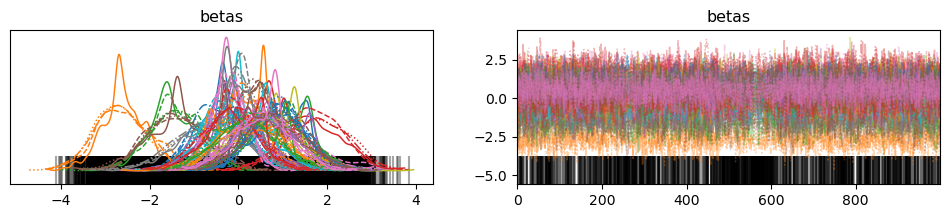

In [81]:
az.plot_trace(idata3_100_9_3, var_names='betas')

### 2nd Trial (n=50, p=9, m=3)

In [84]:
X = data_final.drop(columns=["song_name", "song_popularity", "energy", "liveness", "song_duration_ms", "time_signature"]).values
y = data_final[["song_popularity", "energy", "liveness"]].values

# Too many observations which gear down the process
# Randomly select 5000 indices from the dataset
random_indices = np.random.choice(X.shape[0], 50, replace=False)

# Subset X and y based on the selected indices
X_reduced = X[random_indices]
y_reduced = y[random_indices]

# Verify the new shapes
X_reduced.shape, y_reduced.shape

((50, 9), (50, 3))

In [85]:
df_describe = pd.DataFrame(y_reduced)
df_describe.describe()

0          1          2
count  50.000000  50.000000  50.000000
mean    0.940000   0.760000   0.320000
std     0.239898   0.431419   0.471212
min     0.000000   0.000000   0.000000
25%     1.000000   1.000000   0.000000
50%     1.000000   1.000000   0.000000
75%     1.000000   1.000000   1.000000
max     1.000000   1.000000   1.000000

In [86]:
p = X_reduced.shape[1]
n = X_reduced.shape[0]
m = y_reduced.shape[1]   # dimension of the multivariate outcome
# a_cov = stats.invwishart(df=m+2, scale=np.eye(m)).rvs()

with pm.Model() as GLM:
    
    L,R,std = pm.LKJCholeskyCov("R", n=m, eta=2.0, 
                                sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                compute_corr=True)
    #L = pm.expand_packed_triangular(m, packed_L)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p,m))
    #Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    z = pm.MvNormal('z', mu=X_reduced@betas, cov=R) #cov=Sigma
    # the probit is the inverse cdf of a standard normal
    # the inverse probit is the cdf of a standard normal
    y = pm.Bernoulli('y', p=pm.math.invprobit(z), observed=y_reduced)   
    # Integrating out z would give:
    #y = pm.Bernoulli('y', p=pm.math.invprobit(X@betas), observed=x)   
    
    idata3_50_9_3 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [R, betas, z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 922 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1028 divergences after tuning. Increase `target_accept` or reparameterize.


<Axes: >

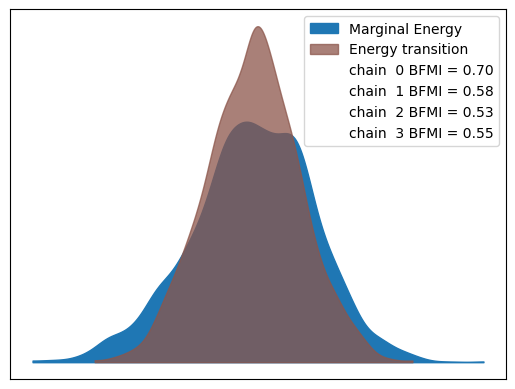

In [87]:
az.plot_energy(idata3_50_9_3)

array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>]], dtype=object)

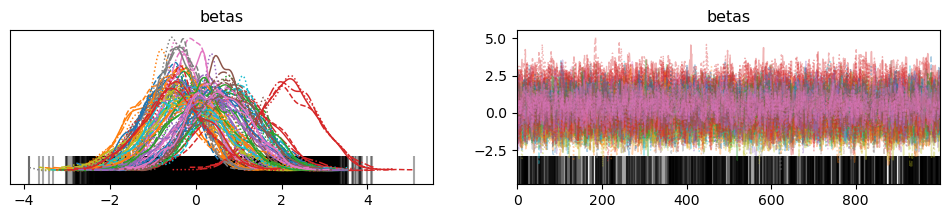

In [88]:
az.plot_trace(idata3_50_9_3, var_names='betas')

### 3rd Trial (n=100, p=6, m=3)

In [104]:
X = data_final.drop(columns=["song_name", "song_popularity", "energy", "liveness", "song_duration_ms", "time_signature", "audio_mode", "audio_valence", "acousticness"]).values
y = data_final[["song_popularity", "energy", "liveness"]].values

# Too many observations which gear down the process
# Randomly select 5000 indices from the dataset
random_indices = np.random.choice(X.shape[0], 100, replace=False)

# Subset X and y based on the selected indices
X_reduced = X[random_indices]
y_reduced = y[random_indices]

# Verify the new shapes
X_reduced.shape, y_reduced.shape

((100, 6), (100, 3))

In [105]:
df_describe = pd.DataFrame(y_reduced)
df_describe.describe()

0           1           2
count  100.000000  100.000000  100.000000
mean     0.870000    0.700000    0.320000
std      0.337998    0.460566    0.468826
min      0.000000    0.000000    0.000000
25%      1.000000    0.000000    0.000000
50%      1.000000    1.000000    0.000000
75%      1.000000    1.000000    1.000000
max      1.000000    1.000000    1.000000

In [93]:
p = X_reduced.shape[1]
n = X_reduced.shape[0]
m = y_reduced.shape[1]   # dimension of the multivariate outcome
# a_cov = stats.invwishart(df=m+2, scale=np.eye(m)).rvs()

with pm.Model() as GLM:
    
    L,R,std = pm.LKJCholeskyCov("R", n=m, eta=2.0, 
                                sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                compute_corr=True)
    #L = pm.expand_packed_triangular(m, packed_L)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p,m))
    #Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    z = pm.MvNormal('z', mu=X_reduced@betas, cov=R) #cov=Sigma
    # the probit is the inverse cdf of a standard normal
    # the inverse probit is the cdf of a standard normal
    y = pm.Bernoulli('y', p=pm.math.invprobit(z), observed=y_reduced)   
    # Integrating out z would give:
    #y = pm.Bernoulli('y', p=pm.math.invprobit(X@betas), observed=x)   
    
    idata3_100_6_3 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [R, betas, z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1164 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 987 divergences after tuning. Increase `target_accept` or reparameterize.


<Axes: >

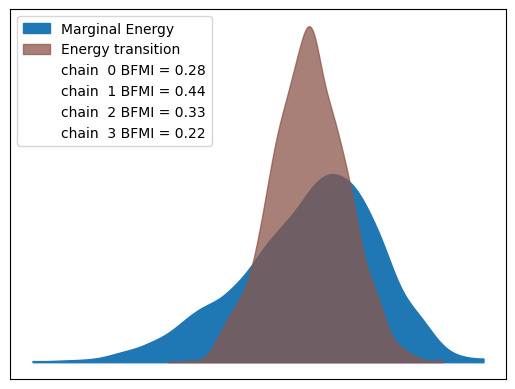

In [94]:
az.plot_energy(idata3_100_6_3)

array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>]], dtype=object)

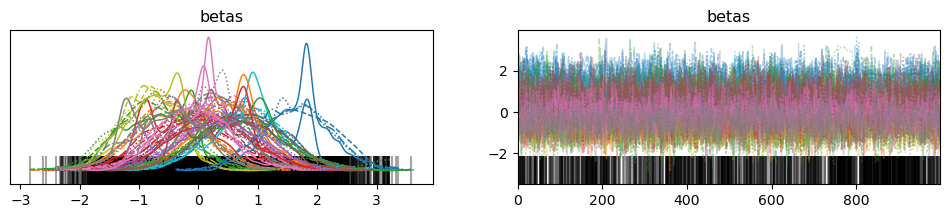

In [95]:
az.plot_trace(idata3_100_6_3, var_names='betas')

### 4th Trial (n=100, p=9, m=5)

In [96]:
data_final['song_duration_ms'] = np.where(
    data_final['song_duration_ms'] <= 0.5, 0, 1
)
data_final['time_signature'] = np.where(
    data_final['time_signature'] <= 0.5, 0, 1
)
X = data_final.drop(columns=["song_name", "song_popularity", "energy", "liveness", "song_duration_ms", "time_signature"]).values
y = data_final[["song_popularity", "energy", "liveness", "song_duration_ms", "time_signature"]].values

# Too many observations which gear down the process
# Randomly select 5000 indices from the dataset
random_indices = np.random.choice(X.shape[0], 100, replace=False)

# Subset X and y based on the selected indices
X_reduced = X[random_indices]
y_reduced = y[random_indices]

# Verify the new shapes
X_reduced.shape, y_reduced.shape

((100, 9), (100, 5))

In [97]:
df_describe = pd.DataFrame(y_reduced)
df_describe.describe()

0           1           2          3       4
count  100.000000  100.000000  100.000000  100.00000  100.00
mean     0.830000    0.810000    0.240000    0.15000    0.01
std      0.377525    0.394277    0.429235    0.35887    0.10
min      0.000000    0.000000    0.000000    0.00000    0.00
25%      1.000000    1.000000    0.000000    0.00000    0.00
50%      1.000000    1.000000    0.000000    0.00000    0.00
75%      1.000000    1.000000    0.000000    0.00000    0.00
max      1.000000    1.000000    1.000000    1.00000    1.00

In [98]:
p = X_reduced.shape[1]
n = X_reduced.shape[0]
m = y_reduced.shape[1]   # dimension of the multivariate outcome
# a_cov = stats.invwishart(df=m+2, scale=np.eye(m)).rvs()

with pm.Model() as GLM:
    
    L,R,std = pm.LKJCholeskyCov("R", n=m, eta=2.0, 
                                sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                compute_corr=True)
    #L = pm.expand_packed_triangular(m, packed_L)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p,m))
    #Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    z = pm.MvNormal('z', mu=X_reduced@betas, cov=R) #cov=Sigma
    # the probit is the inverse cdf of a standard normal
    # the inverse probit is the cdf of a standard normal
    y = pm.Bernoulli('y', p=pm.math.invprobit(z), observed=y_reduced)   
    # Integrating out z would give:
    #y = pm.Bernoulli('y', p=pm.math.invprobit(X@betas), observed=x)   
    
    idata3_100_9_5 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [R, betas, z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2196 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1456 divergences after tuning. Increase `target_accept` or reparameterize.


<Axes: >

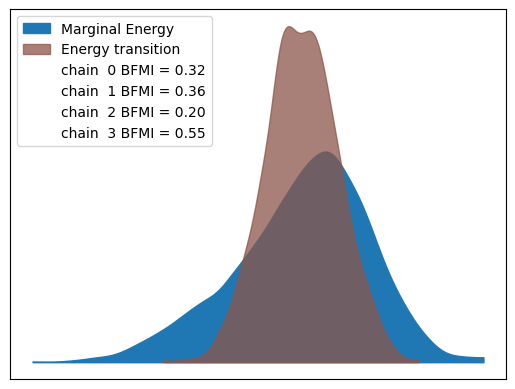

In [99]:
az.plot_energy(idata3_100_9_5)

array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>]], dtype=object)

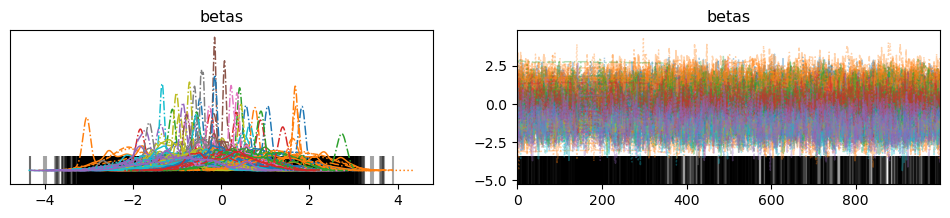

In [100]:
az.plot_trace(idata3_100_9_5, var_names='betas')

### Bayesian Analysis

Across these four trials, we see meaningful differences in how the sampler is exploring the posterior as reflected by the marginal energy (blue) and the energy transition (brown) plots alongside their BFMI values. In the first model (n=100, p=9, m=3), BFMI ranges between about 0.34 and 0.47, suggesting moderately efficient sampling but with some potential room for improvement—chains remain reasonably overlapping, yet do not all reach higher BFMI. In the second model (n=50, p=9, m=3), BFMI values (0.53–0.70) are clearly higher; the chains appear to explore the energy landscape more robustly, likely because there are fewer overall data points but the same parameter dimensionality, resulting in a posterior that is “easier” to navigate. In the third model (n=100, p=6, m=3), two of the chains drop to BFMI values near 0.22–0.28, hinting that the sampler is struggling in parts of the parameter space—possibly due to fewer predictors (p=6) or correlations in the data that hamper efficient exploration. Finally, in the fourth model (n=100, p=9, m=5), the sampling challenge increases further (with five outcome dimensions), and while one chain shows a comfortable BFMI of 0.55, another dips to 0.20, underscoring that higher model complexity (larger m) can demand more tuning or reparameterization to maintain good sampling efficiency. Overall, these plots indicate that model dimensionality (p and m) and sample size (n) can have considerable impact on sampling behavior and BFMI, with the second scenario (n=50, p=9, m=3) demonstrating the most straightforward posterior exploration.

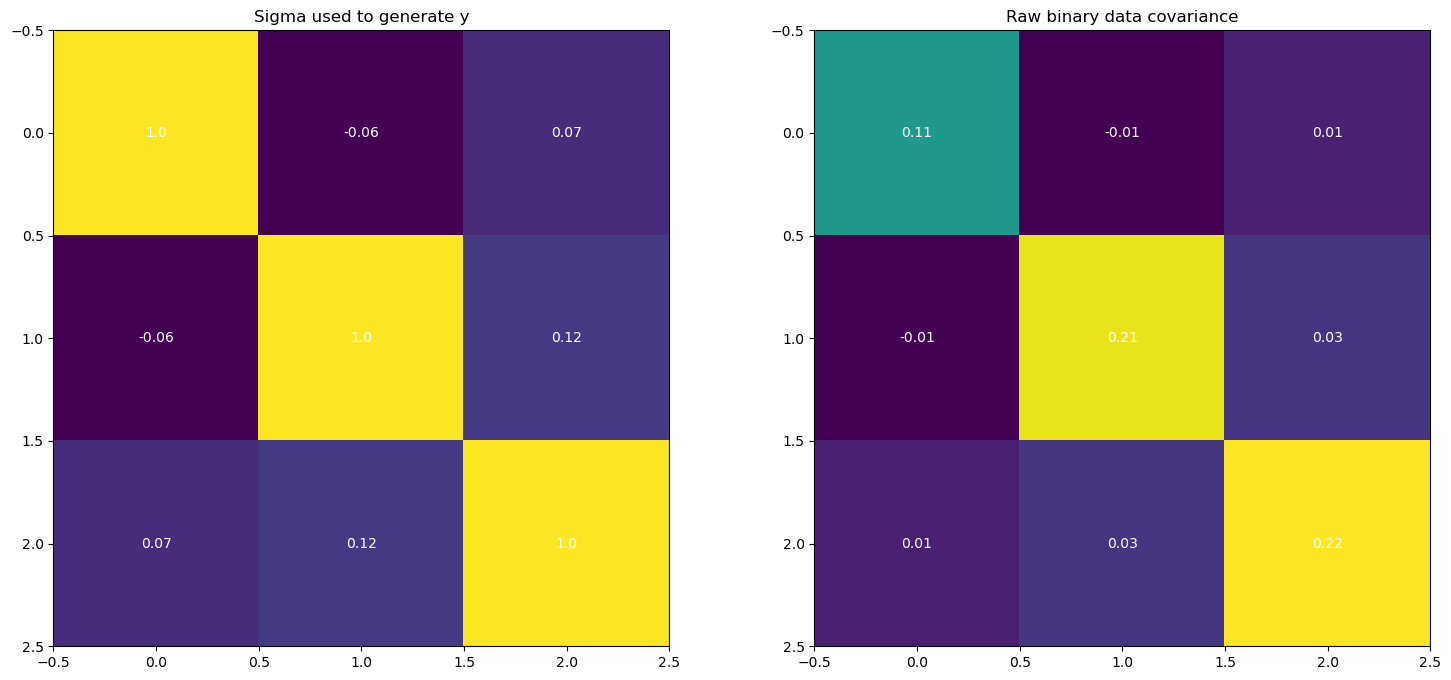

In [121]:
a_cor = np.corrcoef(y_reduced, rowvar=False)

fig,ax = plt.subplots(1,2,figsize=(18,8))
ax[0].imshow(a_cor)
ax[0].set_title(("Sigma used to generate y"))
for i in range(3):
    for j in range(3):
        ax[0].text(i,j,str(round(a_cor[j,i],2)),
                     c='w', ha='center', va='center')
ax[1].imshow(np.cov(y_reduced.T))
ax[1].set_title(("Raw binary data covariance"))
for i in range(3):
    for j in range(3):
        ax[1].text(i,j,str(round(np.cov(y_reduced.T)[j,i],2)),
                     c='w', ha='center', va='center')

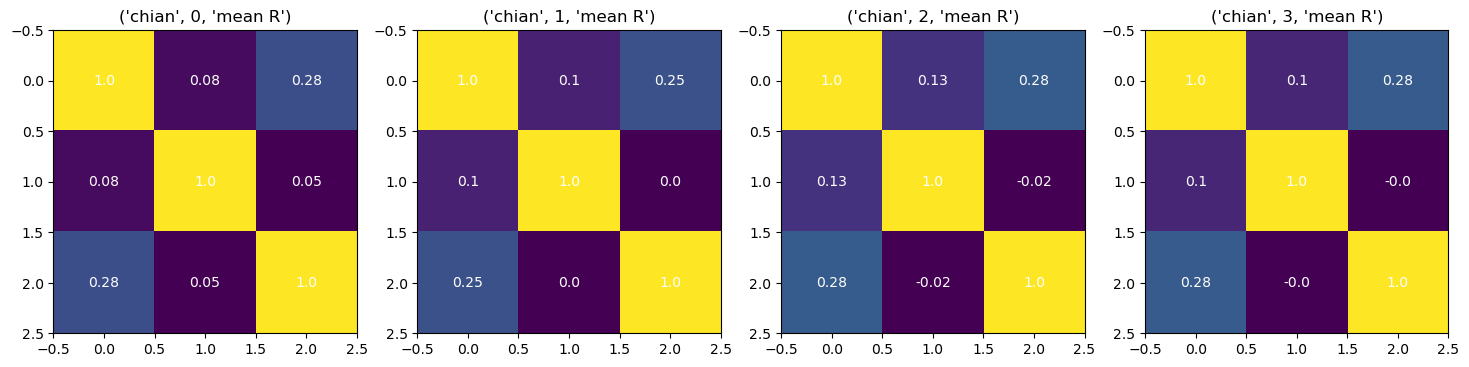

In [125]:
fig,ax = plt.subplots(1,4,figsize=(18,8))

for chain in range(4):
    ax[chain].imshow(idata3_50_9_3.posterior['R_corr'].mean(axis=1)[chain])
    for i in range(3):
        for j in range(3):
            ax[chain].text(i,j,str(round(idata3_50_9_3.posterior['R_corr'].mean(axis=1)[chain].values[j,i],2)),
                             c='w', ha='center', va='center')
    ax[chain].set_title(("chian",chain,"mean R"))

From the diagnostic plots, we can see that the posterior inference is largely stable and that all four chains are sampling from roughly similar posterior landscapes, though small differences in the mean correlation matrices across chains do appear. The raw binary data covariance differs visibly from the “true” covariance used in data generation—which is expected once the underlying continuous outcomes are thresholded into binary form. Each chain’s mean correlation matrix (“mean R”) is comparable but not identical, reflecting some variation in how each chain explores the posterior correlation space. The trace plots for the beta parameters show that all chains mix reasonably well: there are no obvious signs of non-convergence such as persistent drifts or stuck chains, and the distributions overlap substantially. The coefficient draws span a range roughly between -2 and 3 or 4, with different colors representing different beta coefficients. Overall, these diagnostics suggest the sampler is exploring effectively across multiple chains, though the transition to a binary outcome naturally shifts the observed covariance/correlation structure from the original “true” covariance.